# Propagation Project

In [1]:
import numpy as np
from scipy.interpolate import *
from matplotlib import pyplot as plt

## 1. GEO to LEO

$$ P(A > A_{th}) = \sum P(A > A_{th} | \theta_i) P(\theta_i) $$

Questions:

- How can we define the availability threshold? 

csv headers for RAPIDS data:

0. Site number	
1. Satellite number	 
2. Frequency (GHz)	 
3. Elevation angle (deg)	 
4. Elevation probability ()	 
5. Time exceeded (%)	 
6. att_comb (dB)


In [2]:
# load RAPIDS data

aus_37_5_50 = np.genfromtxt("./data/37_austria_5_50/output/ascii/attenuation_total.csv", delimiter=",", skip_header=7, filling_values=0)
aus_37_55_90 = np.genfromtxt("./data/37_austria_55_90/output/ascii/attenuation_total.csv", delimiter=",", skip_header=7, filling_values=0)
nor_37_5_50 = np.genfromtxt("./data/37_norway_5_50/output/ascii/attenuation_total.csv", delimiter=",", skip_header=7, filling_values=0)
nor_37_55_90 = np.genfromtxt("./data/37_norway_55_90/output/ascii/attenuation_total.csv", delimiter=",", skip_header=7, filling_values=0)

aus_37 = np.concatenate((aus_37_5_50, aus_37_55_90))
nor_37 = np.concatenate((nor_37_5_50, nor_37_55_90))

print(np.shape(aus_37))
print(np.shape(nor_37))


(432, 7)
(432, 7)


In [3]:
# load elevation probabilities

p_theta_aus = np.array([1.26916122e-02, 8.47372406e-03, 5.69595155e-03, 
                        3.86117968e-03, 2.81951499e-03, 1.88600128e-03, 
                        1.44770521e-03, 1.01699868e-03, 7.91209792e-04, 
                        6.07163390e-04, 4.85730712e-04, 3.16863394e-04,
                        2.44762741e-04, 2.14404572e-04, 1.36611763e-04, 
                        6.45111101e-05, 2.08712415e-05, 0.00000000e+00])

p_theta_nor = np.array([0.0319405890623310, 0.0201635166903524, 0.0133177494730012,
                        0.0095400547585482, 0.0069406364969708, 0.0054151384806875,
                        0.0042767071252521, 0.0033811411256430, 0.0028593600877351,
                        0.0024817803548491, 0.0021819934312511, 0.0023584502913436,
                        0.0015122163171366, 0.0009638718809353, 0.0006318294022666,
                        0.0003472215634078, 0.0001157405211359, 0.0000000000000000])

In [42]:
atte_max = 47.5 #dB

# max des mins 
# min des max
print(np.shape(aus_37))
print()

print(432/24)
for i in range(len(p_theta_aus)):
    print(aus_37[(i+1)*23, 6])
    
    

attenuation_vector = np.arange(5, 48)

interp_atte_list = [None] * len(p_theta_aus)

for i in range(len(p_theta_aus)):
    
    interp_atte_list[i] = interp1d(aus_37[i*24: (i+1) * 24, 6], aus_37[i*24: (i+1) * 24, 5])


(432, 7)

18.0
4.1164
2.1396
1.4802
1.1674
0.99856
0.91992
0.94477
1.0291
1.3483
1.7653
2.1416
2.783
3.7107
5.0184
6.8235
8.5975
11.094
14.821


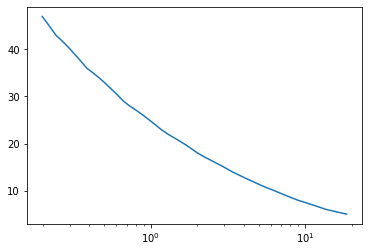

In [33]:
plt.figure()
    # plt.plot(interp_atte_list[0](attenuation_vector), attenuation_vector)
    # plt.plot(aus_37[0*24: (0+1) * 24, 5], aus_37[0*24: (0+1) * 24, 6])

p_atte_tot = np.zeros(len(attenuation_vector))

for i in range(len(attenuation_vector)):
    for j in range(len(p_theta_aus)):

        p_atte_tot[i] += interp_atte_list[j](attenuation_vector[i]) * p_theta_aus[j]

        
plt.semilogx(p_atte_tot / np.sum(p_theta_aus), attenuation_vector)

